<a href="https://colab.research.google.com/github/Annrrt/proyecto2/blob/main/Copia_de_Emociones_con_filtro_equalizeHist%2BSobel_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Importación de bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import pandas as pd
import os
import cv2
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


In [5]:
# Descargar base de datos de Kaggle
data_directory = kagglehub.dataset_download("msambare/fer2013")

In [6]:
import os
import numpy as np
import cv2

def load_images(directory):
    images = []
    labels = []
    for emotion, subdirectory in enumerate(os.listdir(directory)):
        emotion_directory = os.path.join(directory, subdirectory)
        for image_file in os.listdir(emotion_directory):
            image_path = os.path.join(emotion_directory, image_file)
            # Convertir a escala de grises
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (48, 48))

            # Preprocesamiento: Ecualización
            image = cv2.equalizeHist(image)
            # Aplicar el filtro Sobel para detectar bordes en ambas direcciones (horizontal y vertical)
            sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Sobel en dirección x (horizontal)
            sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Sobel en dirección y (vertical)

            # Calcular la magnitud del gradiente
            image = cv2.magnitude(sobel_x, sobel_y)
            # Normalización
            image = image.astype('float32') / 255.0
            image = np.expand_dims(image, -1)

            images.append(image)
            labels.append(emotion)

    return np.array(images), np.array(labels)

# Cargar datos
train_directory = os.path.join(data_directory, 'train')
X_train, y_train = load_images(train_directory)

test_directory = os.path.join(data_directory, 'test')
X_test, y_test = load_images(test_directory)

# Verificación
print("Forma de los datos de entrenamiento:", X_train.shape)
print("Forma de las etiquetas de entrenamiento:", y_train.shape)
print("Forma de los datos de prueba:", X_test.shape)
print("Forma de las etiquetas de prueba:", y_test.shape)


Forma de los datos de entrenamiento: (28709, 48, 48, 1)
Forma de las etiquetas de entrenamiento: (28709,)
Forma de los datos de prueba: (7178, 48, 48, 1)
Forma de las etiquetas de prueba: (7178,)


In [7]:
# Convertir las etiquetas a one-hot encoding
# Ejemplo: 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("Nueva forma de X_train:", X_train.shape)
print("Nueva forma de y_train:", y_train.shape)

Nueva forma de X_train: (28709, 48, 48, 1)
Nueva forma de y_train: (28709, 10)


In [8]:
# Generador de datos con aumentación
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [9]:
# Crear el modelo con mejoras
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida en el conjunto de validación
    patience=5,  # Número de épocas sin mejora para detener el entrenamiento
    restore_best_weights=True  # Restaurar los mejores pesos cuando se detiene el entrenamiento
)
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con generador de datos
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_test, y_test),
    epochs=50,  # puedes ajustar a tu gusto
    verbose=1,  callbacks=[early_stopping]  # Añadir EarlyStopping

)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 338ms/step - accuracy: 0.2313 - loss: 2.0626 - val_accuracy: 0.3151 - val_loss: 1.7119
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.3027 - loss: 1.7231 - val_accuracy: 0.3656 - val_loss: 1.5834
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.3469 - loss: 1.6455 - val_accuracy: 0.3784 - val_loss: 1.6014
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 152s 339ms/step - accuracy: 0.3809 - loss: 1.5732 - val_accuracy: 0.3774 - val_loss: 1.5516
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 156s 347ms/step - accuracy: 0.4018 - loss: 1.5305 - val_accuracy: 0.4625 - val_loss: 1.4236
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 151s 337ms/step - accuracy: 0.4088 - loss: 1.5083 - val_accuracy: 0.4751 - val_loss: 1.3755
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 158s 351ms/step - accuracy: 0.4260 - loss: 1.4673 - val_accuracy: 0.4377 - val_loss: 1.4689
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 152s 338ms/step - accuracy: 0.4384 -

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.4684 - loss: 1.3384
Pérdida en el conjunto de prueba: 1.1878931522369385
Precisión en el conjunto de prueba: 0.5521036386489868


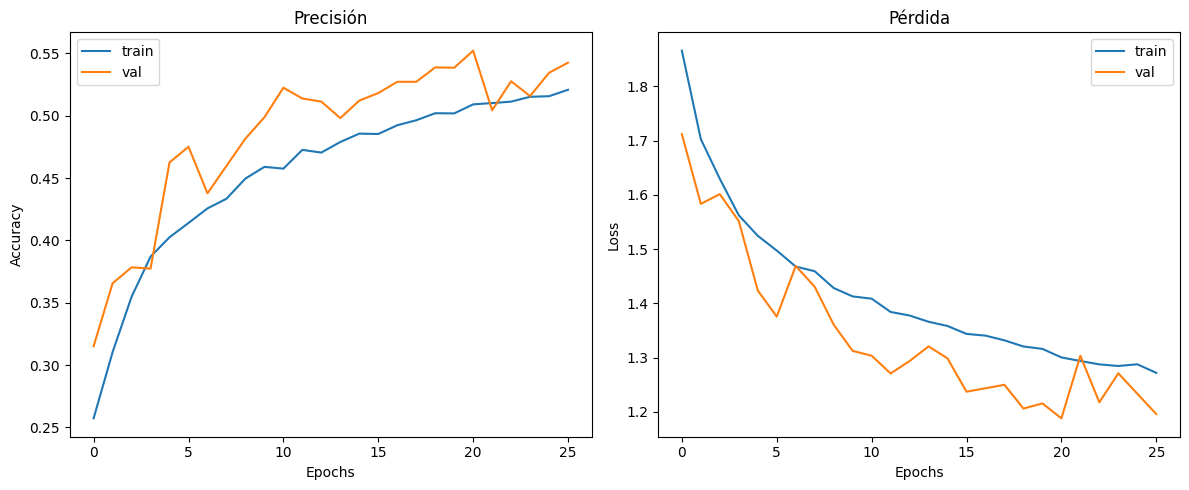

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step


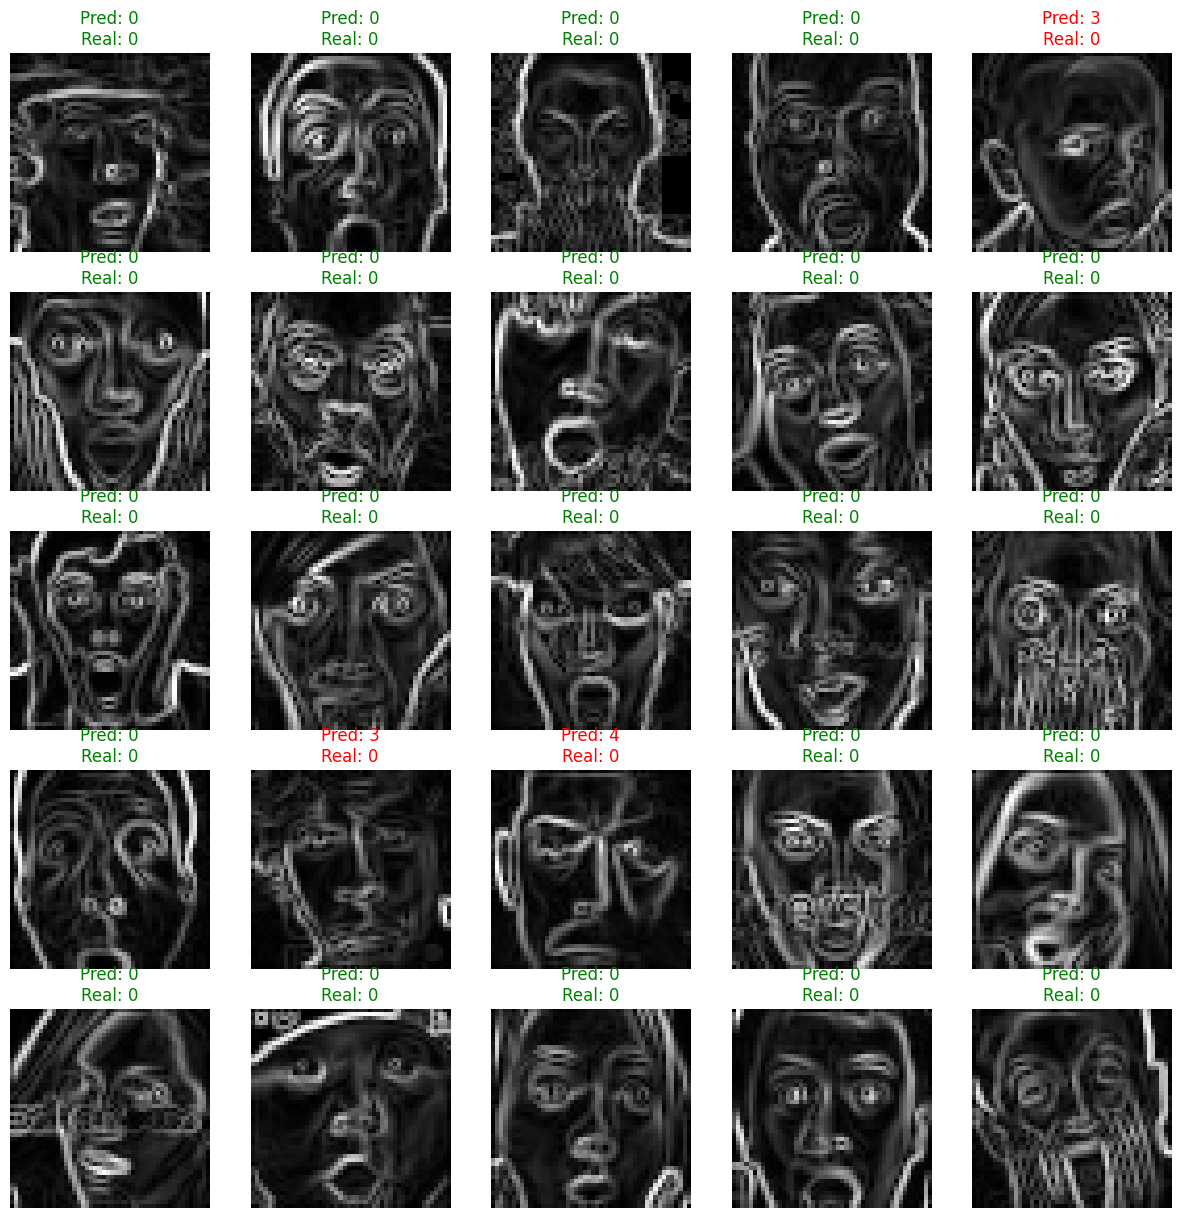

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step


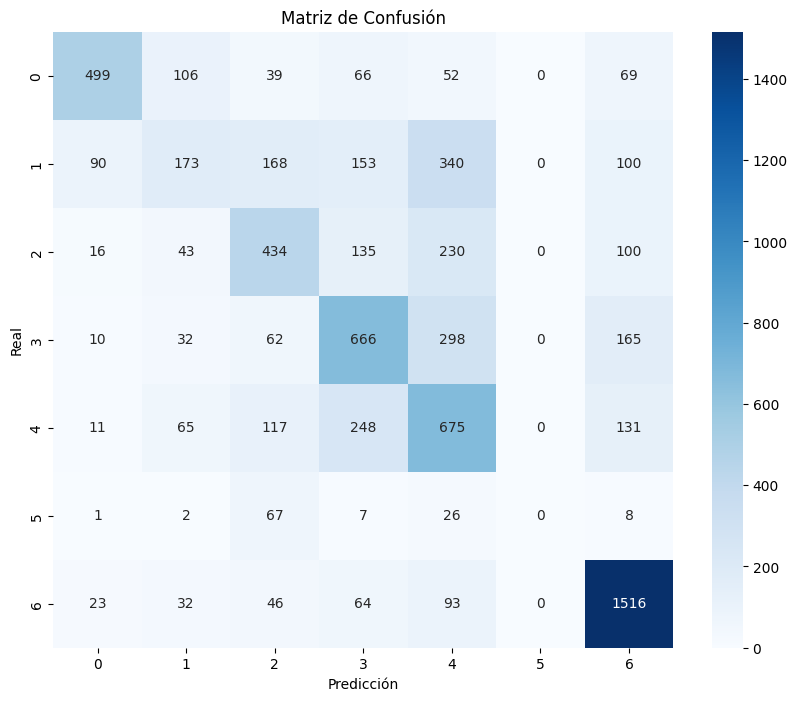

              precision    recall  f1-score   support

           0       0.77      0.60      0.67       831
           1       0.38      0.17      0.23      1024
           2       0.47      0.45      0.46       958
           3       0.50      0.54      0.52      1233
           4       0.39      0.54      0.46      1247
           5       0.00      0.00      0.00       111
           6       0.73      0.85      0.78      1774

    accuracy                           0.55      7178
   macro avg       0.46      0.45      0.45      7178
weighted avg       0.54      0.55      0.53      7178



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida en el conjunto de prueba: {loss}")
print(f"Precisión en el conjunto de prueba: {accuracy}")

# Graficar resultados de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Precisión')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Pérdida')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Hacer predicciones en el conjunto de prueba
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Mostrar algunas predicciones con sus imágenes
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    color = 'green' if predicted_labels[i] == true_labels[i] else 'red'
    plt.title(f"Pred: {predicted_labels[i]}\nReal: {true_labels[i]}", color=color)
    plt.axis('off')
plt.show()


# Matriz de confusión
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Reporte de clasificación
print(classification_report(y_true, y_pred))